# 1.Import data

In [ ]:
import snowflake.connector
from snowflake.connector import cursor
import usaddress
import re
import config_final

In [ ]:
ctx = snowflake.connector.connect(
    user=config_final.user,
    password=config_final.password,
    account=config_final.account
)
cursor = ctx.cursor()

In [ ]:
import pandas as pd
sql_MLS = """SELECT (CASE WHEN CC_PROPERTY_ADDR_DISPLAY_1 IS NULL THEN ADDRESS ELSE CC_PROPERTY_ADDR_DISPLAY_1 END) AS MLS_ADDRESS,
                    OWNER_FULL_NAME AS NAME,
                    CC_PROPERTY_ADDR_POSTAL_CODE AS POSTALCODE
            FROM ATTOM.MLS
            WHERE CC_PROPERTY_ADDR_CITY = 'new york'"""
df_MLS = pd.read_sql(sql_MLS, con=ctx)

In [ ]:
sql_DATATREE = """SELECT SITUSFULLSTREETADDRESS AS DATATREE_ADDRESS,
                         OWNERNAME1FULL,
                         OWNERNAME2FULL,
                         SITUSZIP5
                  FROM DATATREE.ASSESSOR
                  WHERE SITUSCITY = 'new york'"""
df_DATATREE = pd.read_sql(sql_DATATREE, con=ctx)

In [ ]:
df_MLS.head()

,MLS_ADDRESS,NAME,POSTALCODE
0,20 west st apt 17a,hudson homes,10004
1,240 riverside blvd apt 9b,withheld,10069
2,522 w 29th st apt 5b,withheld,10001
3,25 5th ave apt 14c,None,10003
4,1 irving pl apt v9d,None,10003


In [ ]:
df_DATATREE.head()

,DATATREE_ADDRESS,OWNERNAME1FULL,OWNERNAME2FULL,SITUSZIP5
0,305 e 4th st apt 5,karas darko,mount jane,10009
1,463 lexington ave,delmar 36 ar llc,sgn 246 llc,10017
2,300 e 33rd st apt 3p,khan mohammed aslam,pfefferblit susanna,10016
3,170 e 87th st apt e16a,famfa oil ltd,None,10128
4,18 w 90th st,urbs nova cooperative inc,None,10024


In [ ]:
len(df_MLS['MLS_ADDRESS'].unique())/len(df_DATATREE['DATATREE_ADDRESS'].unique())

0.04129401290637929

Max matching ratio couldn't exceed 4%

# 2. First Node - Completely match

In [ ]:
# Drop NaN
df_MLS.dropna(subset=['MLS_ADDRESS'], inplace=True)
df_DATATREE.dropna(subset=['DATATREE_ADDRESS'], inplace=True)


In [ ]:
# Merge the data
df_merge_node1 = pd.merge(df_DATATREE,df_MLS, how = 'left', right_on = ['MLS_ADDRESS', 'POSTALCODE'], 
                          left_on = ['DATATREE_ADDRESS', 'SITUSZIP5'])


In [ ]:
# Compute ratio
first_node_match = len(df_merge_node1[df_merge_node1['MLS_ADDRESS'].notnull()]['MLS_ADDRESS'].unique())
base = len(df_DATATREE['DATATREE_ADDRESS'].unique())
first_node_match_ratio = first_node_match/base
first_node_match_ratio


0.03178306978368077

- Create Matched addresses list

In [ ]:
first_node_match

10924

In [ ]:
MLS_matched_address = []
DATATREE_matched_address = []

In [ ]:
first_node_match_list = list(df_merge_node1[df_merge_node1['MLS_ADDRESS'].notnull()]['MLS_ADDRESS'].unique())
MLS_matched_address.extend(first_node_match_list)
DATATREE_matched_address.extend(first_node_match_list)

In [ ]:
len(MLS_matched_address)

10924

In [ ]:
len(DATATREE_matched_address)

10924

# 3. Second Node - Match after transformation

- Remove punctuation

In [ ]:
# Remove punctuations
from string import punctuation
import re
# punctuation -> space
remove_punctiuation = str.maketrans(punctuation, ' '*len(punctuation))

df_MLS['MLS_ADDRESS'] = df_MLS['MLS_ADDRESS'].apply(lambda x: x.translate(remove_punctiuation))
df_DATATREE['DATATREE_ADDRESS'] = df_DATATREE['DATATREE_ADDRESS'].apply(lambda x: x.translate(remove_punctiuation))
# several spaces -> one space
df_MLS['MLS_ADDRESS'] = df_MLS['MLS_ADDRESS'].apply(lambda x: re.sub(' +', ' ', x))
df_DATATREE['DATATREE_ADDRESS'] = df_DATATREE['DATATREE_ADDRESS'].apply(lambda x: re.sub(' +', ' ', x))


- Create table with splitted addresses

In [ ]:
def get_splited_addr(df,col:str,lt=False):
    import usaddress
    global address
    try:
        address = usaddress.tag(df[col])
    except:
        return None
    if lt:
        return list(address[0])
    else:
        return address
def get_comb_addr(df,splited_col:str):
    test = df[splited_col].to_list()
    values= []
    for i in range(len(test)):
        try:
            values.append(test[i][0])
        except:
            values.append({})
    splited_df = pd.DataFrame(values)
    df.reset_index(inplace=True)
    addr_final = pd.concat([df,splited_df],axis=1)
    del addr_final['index']
    return addr_final

In [ ]:
df1_MLS = df_MLS[:15000] # only take a sample with the first 15000 rows
df1_DATATREE = df_DATATREE[:15000]

In [ ]:
df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)
df1_DATATREE['DATATREE_ADDRESS_Split'] = df1_DATATREE.apply(lambda df1_DATATREE : get_splited_addr(df1_DATATREE,'DATATREE_ADDRESS'), axis = 1)
MLS_ADDRESS_final = get_comb_addr(df1_MLS,'MLS_ADDRESS_Split')
DT_ADDRESS_final = get_comb_addr(df1_DATATREE,'DATATREE_ADDRESS_Split')


/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/437142071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)
/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/437142071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_DATATREE['DATATREE_ADDRESS_Split'] = df1_DATATREE.apply(lambda df1_DATATREE : get_splited_addr(df1_DATATREE,'DATATREE_ADDRESS'), axis = 1)


In [ ]:
MLS_ADDRESS_final.head()

,MLS_ADDRESS,NAME,POSTALCODE,MLS_ADDRESS_Split,AddressNumber,StreetName,StreetNamePostType,OccupancyType,OccupancyIdentifier,StreetNamePreDirectional,StreetNamePostDirectional,StreetNamePreType,PlaceName,StateName,ZipCode,BuildingName,USPSBoxGroupType
0,20 west st apt 17a,hudson homes,10004,"({'AddressNumber': '20', 'StreetName': 'west',...",20,west,st,apt,17a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240 riverside blvd apt 9b,withheld,10069,"({'AddressNumber': '240', 'StreetName': 'river...",240,riverside,blvd,apt,9b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,522 w 29th st apt 5b,withheld,10001,"({'AddressNumber': '522', 'StreetNamePreDirect...",522,29th,st,apt,5b,w,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25 5th ave apt 14c,None,10003,"({'AddressNumber': '25', 'StreetName': '5th', ...",25,5th,ave,apt,14c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 irving pl apt v9d,None,10003,"({'AddressNumber': '1', 'StreetName': 'irving'...",1,irving,pl,apt,v9d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Address cleaning

In [ ]:
print(DT_ADDRESS_final.columns)
abbr_list = ['StreetNamePreDirectional','StreetNamePostType',
             'OccupancyType','StreetNamePostDirectional']
for col in abbr_list:
    print(f'{col}:\n'+ f'{DT_ADDRESS_final[col].unique()}') 

Index(['DATATREE_ADDRESS', 'OWNERNAME1FULL', 'OWNERNAME2FULL', 'SITUSZIP5',
       'DATATREE_ADDRESS_Split', 'AddressNumber', 'StreetNamePreDirectional',
       'StreetName', 'StreetNamePostType', 'OccupancyType',
       'OccupancyIdentifier', 'StreetNamePostDirectional', 'StreetNamePreType',
       'PlaceName', 'StateName', 'ZipCode', 'SubaddressIdentifier',
       'StreetNamePreModifier'],
      dtype='object')
StreetNamePreDirectional:
['e' nan 'w' 'n' 'south' 's' 'west']
StreetNamePostType:
['st' 'ave' 'blvd' nan 'plz' 'pl' 'dr' 'park' 'row' 'hl' 'ter' 'sq' 'ln'
 'cir' 'avenue' 'garden' 'sta' 'ct' 'vlg' 'br' 'btf' 'phj']
OccupancyType:
['apt' nan 'ste' 'rm' 'lbby' 'fl' 'ph' 'ofc' 'st' 'oor' 'pla' 'unit' 'ret']
StreetNamePostDirectional:
[nan 's' 'w' 'e' 'n' 'south' 'west']


In [ ]:
print(MLS_ADDRESS_final.columns)
abbr_list = ['StreetNamePreDirectional','StreetNamePostType',
             'OccupancyType','StreetNamePostDirectional']
for col in abbr_list:
    print(f'{col}:\n'+ f'{MLS_ADDRESS_final[col].unique()}') 

Index(['MLS_ADDRESS', 'NAME', 'POSTALCODE', 'MLS_ADDRESS_Split',
       'AddressNumber', 'StreetName', 'StreetNamePostType', 'OccupancyType',
       'OccupancyIdentifier', 'StreetNamePreDirectional',
       'StreetNamePostDirectional', 'StreetNamePreType', 'PlaceName',
       'StateName', 'ZipCode', 'BuildingName', 'USPSBoxGroupType'],
      dtype='object')
StreetNamePreDirectional:
[nan 'w' 'e' 'west' 's' 'n' 'east' 'w w']
StreetNamePostType:
['st' 'blvd' 'ave' 'pl' 'park' nan 'plz' 'dr' 'row' 'ter' 'ln' 'avenue'
 'phh' 'ct' 'street' 'cres' 'cir' 'gdn' 'sq' 'rd']
OccupancyType:
['apt' nan 'fl' 'unit' 'ph' 'ste' 'rm' 'frnt' 'ofc' 'roof']
StreetNamePostDirectional:
[nan 'n' 'w' 's' 'e' 'west']


In [ ]:
df = pd.read_csv('suffix_abbreviations_converted.csv')
StreetNamePostType_dict = dict(zip(df.common_name, df.abbr))

In [ ]:
StreetNamePostType_dict

{'allee': 'aly',
 'alley': 'aly',
 'ally': 'aly',
 'aly': 'aly',
 'anex': 'anx',
 'annex': 'anx',
 'annx': 'anx',
 'anx': 'anx',
 'arc': 'arc',
 'arcade': 'arc',
 'av': 'ave',
 'ave': 'ave',
 'aven': 'ave',
 'avenu': 'ave',
 'avenue': 'ave',
 'avn': 'ave',
 'avnue': 'ave',
 'bayoo': 'byu',
 'bayou': 'byu',
 'bch': 'bch',
 'beach': 'bch',
 'bend': 'bnd',
 'bnd': 'bnd',
 'blf': 'blf',
 'bluf': 'blf',
 'bluff': 'blf',
 'bluffs': 'blfs',
 'bot': 'btm',
 'btm': 'btm',
 'bottm': 'btm',
 'bottom': 'btm',
 'blvd': 'blvd',
 'boul': 'blvd',
 'boulevard': 'blvd',
 'boulv': 'blvd',
 'br': 'br',
 'brnch': 'br',
 'branch': 'br',
 'brdge': 'brg',
 'brg': 'brg',
 'bridge': 'brg',
 'brk': 'brk',
 'brook': 'brk',
 'brooks': 'brks',
 'burg': 'bg',
 'burgs': 'bgs',
 'byp': 'byp',
 'bypa': 'byp',
 'bypas': 'byp',
 'bypass': 'byp',
 'byps': 'byp',
 'camp': 'cp',
 'cp': 'cp',
 'cmp': 'cp',
 'canyn': 'cyn',
 'canyon': 'cyn',
 'cnyn': 'cyn',
 'cape': 'cpe',
 'cpe': 'cpe',
 'causeway': 'cswy',
 'causwa': 'cswy'

In [ ]:
def get_str_replace(MLS_ADDRESS_final,DT_ADDRESS_final):
    #need to change file path
    df = pd.read_csv('/Users/yiweihou/Downloads/Roc360/suffix_abbreviations_converted.csv')
    StreetNamePostType_dict = dict(zip(df.common_name, df.abbr))
    StreetNameDirectional_dict = {'west': 'w', 'south': 's', 'north': 'n','east': 'e'}

    DT_ADDRESS_final.replace({"StreetNamePreDirectional": StreetNameDirectional_dict},inplace=True)
    DT_ADDRESS_final.replace({"StreetNamePostType": StreetNamePostType_dict},inplace=True)

    MLS_ADDRESS_final.replace({"StreetNamePreDirectional": StreetNameDirectional_dict},inplace=True)
    MLS_ADDRESS_final.replace({"StreetNamePostType": StreetNamePostType_dict},inplace=True)
    return MLS_ADDRESS_final,DT_ADDRESS_final

In [ ]:
# convert address format (direction, abbreviation)
MLS_ADDRESS_final,DT_ADDRESS_final=get_str_replace(MLS_ADDRESS_final,DT_ADDRESS_final)

In [ ]:
print(MLS_ADDRESS_final['StreetNamePreDirectional'].unique())
print(DT_ADDRESS_final['StreetNamePreDirectional'].unique())
print(MLS_ADDRESS_final['StreetNamePostType'].unique())
print(DT_ADDRESS_final['StreetNamePostType'].unique())

[nan 'w' 'e' 's' 'n' 'w w']
['e' nan 'w' 'n' 's']
['st' 'blvd' 'ave' 'pl' 'park' nan 'plz' 'dr' 'row' 'ter' 'ln' 'phh' 'ct'
 'cres' 'cir' 'gdn' 'sq' 'rd']
['st' 'ave' 'blvd' nan 'plz' 'pl' 'dr' 'park' 'row' 'hl' 'ter' 'sq' 'ln'
 'cir' 'gdn' 'sta' 'ct' 'vlg' 'br' 'btf' 'phj']


In [ ]:
DT_ADDRESS_final[DT_ADDRESS_final['StreetNamePreDirectional'] == '62']

,DATATREE_ADDRESS,OWNERNAME1FULL,OWNERNAME2FULL,SITUSZIP5,DATATREE_ADDRESS_Split,AddressNumber,StreetNamePreDirectional,StreetName,StreetNamePostType,OccupancyType,OccupancyIdentifier,StreetNamePostDirectional,StreetNamePreType,PlaceName,StateName,ZipCode,SubaddressIdentifier,StreetNamePreModifier


- Merge

In [ ]:
df_merge_node2 = pd.merge(DT_ADDRESS_final, MLS_ADDRESS_final,
                    how = 'left',
                    left_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType',
               'OccupancyIdentifier','OccupancyType', 'SITUSZIP5'],
                    right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType',
               'OccupancyIdentifier','OccupancyType', 'POSTALCODE'])

In [ ]:
MLS_matched_address.extend(df_merge_node2[df_merge_node2['MLS_ADDRESS'].notnull()]['MLS_ADDRESS'].unique())
MLS_matched_address = list(set(MLS_matched_address))
len(MLS_matched_address)

10947

In [ ]:
DATATREE_matched_address.extend(df_merge_node2[df_merge_node2['MLS_ADDRESS'].notnull()]['DATATREE_ADDRESS'].unique())
DATATREE_matched_address = list(set(DATATREE_matched_address))
len(DATATREE_matched_address)

10958

In [ ]:
second_node_match = len(MLS_matched_address)
second_node_match_ratio = second_node_match/base
second_node_match_ratio

0.03184998763474491

In [ ]:
MLS_unmatched_node2 = MLS_ADDRESS_final[MLS_ADDRESS_final['MLS_ADDRESS'].apply(lambda x: x not in MLS_matched_address)]
DATATREE_unmatched_node2 = DT_ADDRESS_final[DT_ADDRESS_final['DATATREE_ADDRESS'].apply(lambda x: x not in DATATREE_matched_address)]
MLS_unmatched_node2.reset_index(inplace=True)
DATATREE_unmatched_node2.reset_index(inplace=True)
del MLS_unmatched_node2['index']
del DATATREE_unmatched_node2['index']

# 4. Third Node - Match with names

### 4.1 Name cleaning

#### 4.1.1  remove punctuations

In [ ]:
from string import punctuation
import re
# punctuation -> space
def remove_punct(x):
    remove_punctiuation = str.maketrans(punctuation, ' '*len(punctuation))
    if x is not None:
        x = str(x)
        x = x.translate(remove_punctiuation)
        return x
    else:
        return x
MLS_unmatched_node2['NAME'] = MLS_unmatched_node2['NAME'].apply(lambda x: remove_punct(x))
DATATREE_unmatched_node2['OWNERNAME1FULL'] = DATATREE_unmatched_node2['OWNERNAME1FULL'].apply(lambda x: remove_punct(x))
# several spaces -> one space
def conver_space(x):
    if x is not None:
        x = str(x)
        x = re.sub(' +', ' ', x)
        return x.strip()
    else:
        return x
MLS_unmatched_node2['NAME'] = MLS_unmatched_node2['NAME'].apply(lambda x: conver_space(x))
DATATREE_unmatched_node2['OWNERNAME1FULL'] = DATATREE_unmatched_node2['OWNERNAME1FULL'].apply(lambda x: conver_space(x))


/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/4080080342.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLS_unmatched_node2['NAME'] = MLS_unmatched_node2['NAME'].apply(lambda x: remove_punct(x))
/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/4080080342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATATREE_unmatched_node2['OWNERNAME1FULL'] = DATATREE_unmatched_node2['OWNERNAME1FULL'].apply(lambda x: remove_punct(x))
/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000

#### 4.1.2 Deal with corporation related names

- Compute the frequency of the words

In [ ]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    new = list(filter(None,new))

    corpus=[word for i in new for word in i]
    corpus=list(filter(lambda x: len(x) > 1,corpus))#longer than 1
    
    
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

In [ ]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    new = list(filter(None,new))

    corpus=[word for i in new for word in i]
    corpus=list(filter(lambda x: len(x) > 1,corpus))#longer than 1

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.rcParams['figure.figsize']=10,10
    sns.barplot(x=y,y=x)

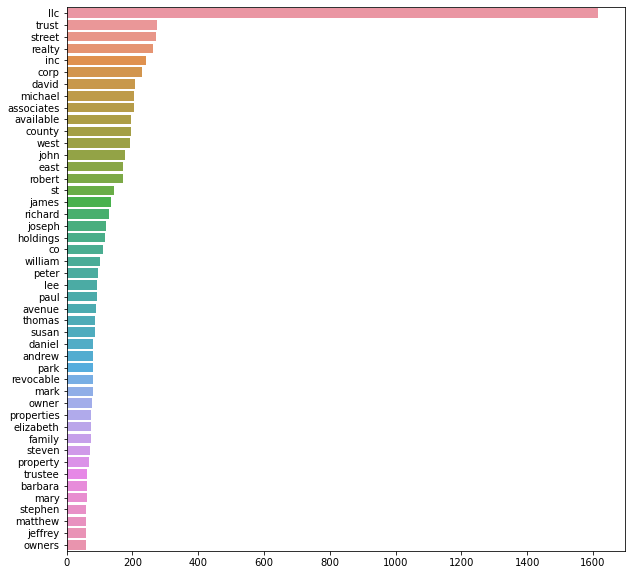

In [ ]:
plot_top_non_stopwords_barchart(DT_ADDRESS_final['OWNERNAME1FULL'])

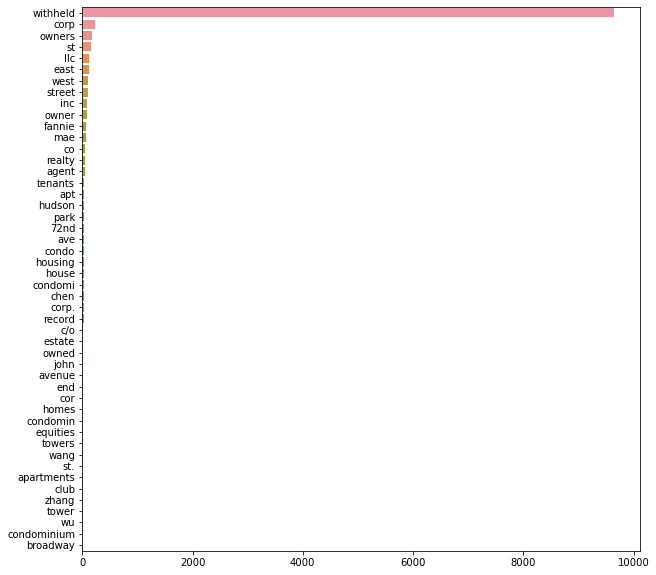

In [ ]:
plot_top_non_stopwords_barchart(MLS_ADDRESS_final['NAME'])

In [ ]:
possible_word_list_DT = ['corp', 'llc', 'realty', 'trust', 'inc', 'associates', 'co', 'holdings', 'owner',
                      'properties', 'trustee', 'housing', 'family', 'owners', 'development']
possible_word_list_MLS = ['corp', 'owners', 'llc', 'inc', 'owner', 'realty', 'co', 'tenants', 'agent', 'condo',
                         'house', 'homes', 'housing', 'record', 'estate', 'servicing', 'cor', 'condonminium',
                         'owned', 'portfolio', 'owne', 'trust']
other = ['ltd']

- Replace the words related to corporations

In [ ]:
# Use the words to find possible replacement in sheets
# Incorpate - inc is kind of complicated, so no replacement
replace_name_dict_complicated = {'limited liability company': 'llc', 
                                 'company limited partnership': 'company ltd partnership', 
                                 'co limited partnership': 'co ltd partnership', 'company ltd': 'co ltd',
                                 'associates': 'assoc', 'limited liability partnerships': 'llp',
                                 'properties': 'prop', 'association': 'assn', 'estate': 'est',
                                 'condonminium': 'condo'}

MLS_unmatched_node2.replace({"NAME": replace_name_dict_complicated},inplace=True)
DATATREE_unmatched_node2.replace({"OWNERNAME1FULL": replace_name_dict_complicated},inplace=True)

/Users/yiweihou/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [ ]:
replace_name_dict_tail = {'incorporated': 'inc', 'corporation': 'corp', 'authority': 'a'}
def replace_corp(x, replace_dict):
    if x is None:
        return x
    import re
    for key, value in replace_dict.items():
        key = '(.*) ' + key + '$'
        if re.match(key, x):
            return re.search(key, x).group(1) + ' ' + value
    return x

In [ ]:
MLS_unmatched_node2['NAME'] = MLS_unmatched_node2['NAME'].apply(lambda x: replace_corp(x, replace_name_dict_tail))
DATATREE_unmatched_node2['OWNERNAME1FULL'] = DATATREE_unmatched_node2['OWNERNAME1FULL'].apply(lambda  x: replace_corp(str(x), replace_name_dict_tail))

/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2626558335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLS_unmatched_node2['NAME'] = MLS_unmatched_node2['NAME'].apply(lambda x: replace_corp(x, replace_name_dict_tail))
/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2626558335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATATREE_unmatched_node2['OWNERNAME1FULL'] = DATATREE_unmatched_node2['OWNERNAME1FULL'].apply(lambda  x: replace_corp(str(x), replace_name_dict

#### 4.1.3 Order the names

In [ ]:
def create_pseudo_name(df_col):
    """
    :param df_col: the name col
    :return:
    """
    assert isinstance(df_col, pd.Series), "It is not a pd.Series"
    df_col = df_col.apply(lambda x: " ".join(sorted(x.split())) if isinstance(x, str) and len(x.split()) <= 3 else x)

    return df_col

In [ ]:
MLS_unmatched_node2['NAME'] = create_pseudo_name(MLS_unmatched_node2['NAME'])
DATATREE_unmatched_node2['OWNERNAME1FULL'] = create_pseudo_name(DATATREE_unmatched_node2['OWNERNAME1FULL'])

/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2049998946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLS_unmatched_node2['NAME'] = create_pseudo_name(MLS_unmatched_node2['NAME'])
/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2049998946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATATREE_unmatched_node2['OWNERNAME1FULL'] = create_pseudo_name(DATATREE_unmatched_node2['OWNERNAME1FULL'])


### 4.2 Match table to using addresses whose owners only own one address in the DATATREE table

- Find the addresses whose owners only own one address in the DATATREE table

In [ ]:
only_once = DATATREE_unmatched_node2[['DATATREE_ADDRESS','OWNERNAME1FULL']].groupby('OWNERNAME1FULL').count()
only_once = only_once[only_once['DATATREE_ADDRESS']==1]
remaining = only_once[only_once['DATATREE_ADDRESS']> 1]
once_list = list(only_once['DATATREE_ADDRESS'].index)
DATATREE_only_once = DATATREE_unmatched_node2[DATATREE_unmatched_node2['OWNERNAME1FULL'].isin(once_list)]

In [ ]:
df_merge_node3 = pd.merge(DATATREE_only_once, MLS_unmatched_node2, how = 'left', 
                            left_on = ['AddressNumber', 'StreetName', 'StreetNamePreDirectional', 'StreetNamePostType', 'SITUSZIP5'], 
                            right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType', 'POSTALCODE'])

In [ ]:
df_merge_node3 = df_merge_node3[df_merge_node3['MLS_ADDRESS'].notnull()]

- only contains that one address has apt and the other does not have

In [ ]:
def is_null(x, y):
    if (x == 'nan') and (y == 'nan'):
        return True
    else:
        return False
df_merge_node3['Occupancy_x_none'] = df_merge_node3.apply(lambda x: is_null(str(x['OccupancyType_x']), str(x['OccupancyIdentifier_x'])), axis=1)
df_merge_node3['Occupancy_y_none'] = df_merge_node3.apply(lambda x: is_null(str(x['OccupancyType_y']), str(x['OccupancyIdentifier_y'])), axis=1)

In [ ]:
df_merge_node3 = df_merge_node3[df_merge_node3['Occupancy_y_none'] != df_merge_node3['Occupancy_x_none']]

- Compute the fuzz ratios

In [ ]:
# !pip install thefuzz

In [ ]:
from thefuzz import fuzz
df_merge_node3['NAME_FUZZY_1'] = df_merge_node3.apply(lambda x: fuzz.ratio(str(x['NAME']), str(x['OWNERNAME1FULL'])), axis=1)
df_merge_node3['NAME_FUZZY_sort_1'] = df_merge_node3.apply(lambda x: fuzz.token_sort_ratio(str(x['NAME']), str(x['OWNERNAME1FULL'])), axis=1)

/Users/yiweihou/opt/anaconda3/lib/python3.9/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
df_merge_node3[df_merge_node3["NAME"] == df_merge_node3["OWNERNAME1FULL"]][['MLS_ADDRESS', 'DATATREE_ADDRESS','NAME', 'OWNERNAME1FULL']]

,MLS_ADDRESS,DATATREE_ADDRESS,NAME,OWNERNAME1FULL
12258,215 e 73rd st 9d,215 e 73rd st,215 e 73rd owner corp,215 e 73rd owner corp
12259,215 e 73rd st 8e,215 e 73rd st,215 e 73rd owner corp,215 e 73rd owner corp
12260,215 e 73rd st 5g,215 e 73rd st,215 e 73rd owner corp,215 e 73rd owner corp
12261,215 e 73rd st 6a,215 e 73rd st,215 e 73rd owner corp,215 e 73rd owner corp


- Add address with same names to matched list

In [ ]:
df_merge_node3_matched = df_merge_node3[df_merge_node3["NAME"] == df_merge_node3["OWNERNAME1FULL"]]

In [ ]:
MLS_matched_address.extend(list(df_merge_node3_matched['MLS_ADDRESS'].unique()))
MLS_matched_address = list(set(MLS_matched_address))
len(MLS_matched_address)

10951

In [ ]:
DATATREE_matched_address.extend(list(df_merge_node3_matched['DATATREE_ADDRESS'].unique()))
DATATREE_matched_address = list(set(DATATREE_matched_address))
len(DATATREE_matched_address)

10959

In [ ]:
third_node_match = len(MLS_matched_address)
base = len(df_DATATREE['DATATREE_ADDRESS'].unique())
third_node_match_ratio = third_node_match/base
third_node_match_ratio

0.0318620890311318

- Study fuzzy ratios: there are misspelled names but it's hard to find the threshold

In [ ]:
df_merge_node3 = df_merge_node3[df_merge_node3['MLS_ADDRESS'].notnull()]

In [ ]:
df_merge_node3[(df_merge_node3["NAME_FUZZY_1"] > 75) & (df_merge_node3["NAME_FUZZY_1"] < 100)].sort_values(by="NAME_FUZZY_1" , ascending=False)[['MLS_ADDRESS', 'DATATREE_ADDRESS',
                                                                                                       'NAME', 'OWNERNAME1FULL']]

,MLS_ADDRESS,DATATREE_ADDRESS,NAME,OWNERNAME1FULL


In [ ]:
df_merge_node3[df_merge_node3["NAME_FUZZY_1"] < 75].sort_values(by="NAME_FUZZY_1" , ascending=False)[['MLS_ADDRESS', 'DATATREE_ADDRESS',
                                                                                                       'NAME', 'OWNERNAME1FULL']].head(20)

,MLS_ADDRESS,DATATREE_ADDRESS,NAME,OWNERNAME1FULL
782,301 e 79th st,301 e 79th st apt 4c,withheld,leff mitchell
11209,509 e 77th st,509 e 77th st 1 0 6p,withheld,hsieh michael
11675,244 seaman ave,244 seaman ave 4h,fund margreat,dimarco martina
7973,5 tudor city pl,5 tudor city pl apt b20,withheld,codispoti michael
11647,244 seaman ave,244 seaman ave 4a,fund margreat,domue michael
4095,120 e 75th st 5a,120 e 75th st gordo,withheld,hercules
14622,204 w 10th st,204 w 10th st apt 24,justin oh,jessica tsai
14597,509 e 77th st,509 e 77th st 2 0 5m,withheld,joseph whelan
9580,5 tudor city pl,5 tudor city pl apt 1205,withheld,christopher e pelka
10701,128 central park s 2a,128 central park s,withheld,edward michael platt


- Don't use fuzzy ratios here won't affect much

In [ ]:
len(df_merge_node3[(df_merge_node3["NAME_FUZZY_1"] > 75) & (df_merge_node3["NAME_FUZZY_1"] < 100)]['MLS_ADDRESS'].unique())

0

# 4. Fourth Node - Match with rooms combined with name fuzzy ratios

In [ ]:
import pandas as pd
sql_MLS = """SELECT (CASE WHEN CC_PROPERTY_ADDR_DISPLAY_1 IS NULL THEN ADDRESS ELSE CC_PROPERTY_ADDR_DISPLAY_1 END) AS MLS_ADDRESS,
                    OWNER_FULL_NAME AS NAME,
                    CC_PROPERTY_ADDR_POSTAL_CODE AS POSTALCODE,
                    rooms,
                    bedrooms,
                    full_baths,
                    half_baths
            FROM ATTOM.MLS
            WHERE CC_PROPERTY_ADDR_CITY = 'new york'"""
df_MLS_room = pd.read_sql(sql_MLS, con=ctx)

In [ ]:
sql_DATATREE = """SELECT SITUSFULLSTREETADDRESS AS DATATREE_ADDRESS,
                         OWNERNAME1FULL,
                         OWNERNAME2FULL,
                         SITUSZIP5,
                         Bedrooms,
                         TotalRooms,
                         BathFull,
                         BathsPartialNbr
                  FROM DATATREE.ASSESSOR
                  WHERE SITUSCITY = 'new york'"""
df_DATATREE_room = pd.read_sql(sql_DATATREE, con=ctx)

In [ ]:
df_MLS_room.dropna(subset=['MLS_ADDRESS'], inplace=True)
df_DATATREE_room.dropna(subset=['DATATREE_ADDRESS'], inplace=True)

In [ ]:
MLS_unmatched_node3 = df_MLS_room[df_MLS_room['MLS_ADDRESS'].apply(lambda x: x not in MLS_matched_address)]
DATATREE_unmatched_node3 = df_DATATREE_room[df_DATATREE_room['DATATREE_ADDRESS'].apply(lambda x: x not in DATATREE_matched_address)]

In [ ]:
MLS_unmatched_node3[['ROOMS', 'BEDROOMS', 'FULL_BATHS', 'HALF_BATHS']].value_counts()

ROOMS  BEDROOMS  FULL_BATHS  HALF_BATHS
5.0    2.0       2.0         1.0           214
3.0    1.0       1.0         1.0           190
4.0    2.0       1.0         1.0           159
5.0    2.0       1.0         1.0           113
4.0    1.0       1.0         1.0            99
                                          ... 
       3.0       2.0         1.0             2
8.0    3.0       1.0         1.0             2
6.0    4.0       2.0         1.0             1
5.0    3.0       1.0         3.0             1
12.0   8.0       8.0         8.0             1
Length: 77, dtype: int64

- In datatree, almost all of the records are with 0 bedrooms, bathfull, bathspartialnbr; only use totalrooms to match

In [ ]:
DATATREE_unmatched_node3[['BEDROOMS', 'TOTALROOMS', 'BATHFULL', 'BATHSPARTIALNBR']].value_counts()

BEDROOMS  TOTALROOMS  BATHFULL  BATHSPARTIALNBR
0         0           0         0                  317904
          3           0         0                   11514
          4           0         0                    6468
          2           0         0                    6322
          5           0         0                    2313
          1           0         0                     890
          6           0         0                     712
          7           0         0                     267
          8           0         0                     153
          80          0         0                      49
          9           0         0                      43
          11          0         0                      33
          10          0         0                      22
          12          0         0                      13
          24          0         0                      10
          13          0         0                       7
          16          0 

In [ ]:
MLS_unmatched_node3.reset_index(inplace=True)
DATATREE_unmatched_node3.reset_index(inplace=True)
del MLS_unmatched_node3['index']
del DATATREE_unmatched_node3['index']

In [ ]:
df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)
df1_DATATREE['DATATREE_ADDRESS_Split'] = df1_DATATREE.apply(lambda df1_DATATREE : get_splited_addr(df1_DATATREE,'DATATREE_ADDRESS'), axis = 1)
MLS_ADDRESS_final = get_comb_addr(df1_MLS,'MLS_ADDRESS_Split')
DT_ADDRESS_final = get_comb_addr(df1_DATATREE,'DATATREE_ADDRESS_Split')

/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2064281604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)
/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2064281604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_DATATREE['DATATREE_ADDRESS_Split'] = df1_DATATREE.apply(lambda df1_DATATREE : get_splited_addr(df1_DATATREE,'DATATREE_ADDRESS'), axis = 1)


In [ ]:
df_merge_node4 = pd.merge(DT_ADDRESS_final, MLS_ADDRESS_final, how = 'left', 
                            left_on = ['AddressNumber', 'StreetName', 'StreetNamePreDirectional', 'StreetNamePostType', 'SITUSZIP5'], 
                            right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType', 'POSTALCODE'])

In [ ]:
df_merge_node4

,level_0_x,DATATREE_ADDRESS,OWNERNAME1FULL,OWNERNAME2FULL,SITUSZIP5,DATATREE_ADDRESS_Split,AddressNumber,StreetNamePreDirectional,StreetName,StreetNamePostType,...,MLS_ADDRESS_Split,OccupancyType_y,OccupancyIdentifier_y,StreetNamePostDirectional_y,StreetNamePreType_y,PlaceName_y,StateName_y,ZipCode_y,BuildingName,USPSBoxGroupType
0,0,305 e 4th st apt 5,karas darko,mount jane,10009,"({'AddressNumber': '305', 'StreetNamePreDirect...",305,e,4th,st,...,"({'AddressNumber': '305', 'StreetNamePreDirect...",apt,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,305 e 4th st apt 5,karas darko,mount jane,10009,"({'AddressNumber': '305', 'StreetNamePreDirect...",305,e,4th,st,...,"({'AddressNumber': '305', 'StreetNamePreDirect...",apt,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,463 lexington ave,delmar 36 ar llc,sgn 246 llc,10017,"({'AddressNumber': '463', 'StreetName': 'lexin...",463,NaN,lexington,ave,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,300 e 33rd st apt 3p,khan mohammed aslam,pfefferblit susanna,10016,"({'AddressNumber': '300', 'StreetNamePreDirect...",300,e,33rd,st,...,"({'AddressNumber': '300', 'StreetNamePreDirect...",apt,4c,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,300 e 33rd st apt 3p,khan mohammed aslam,pfefferblit susanna,10016,"({'AddressNumber': '300', 'StreetNamePreDirect...",300,e,33rd,st,...,"({'AddressNumber': '300', 'StreetNamePreDirect...",apt,15a,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75618,14997,244 seaman ave 3a,bujgoli corneliu,None,10034,"({'AddressNumber': '244', 'StreetName': 'seama...",244,NaN,seaman,ave,...,"({'AddressNumber': '244', 'StreetName': 'seama...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75619,14997,244 seaman ave 3a,bujgoli corneliu,None,10034,"({'AddressNumber': '244', 'StreetName': 'seama...",244,NaN,seaman,ave,...,"({'AddressNumber': '244', 'StreetName': 'seama...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75620,14998,1239 madison ave 9e,rose associates,None,10128,"({'AddressNumber': '1239', 'StreetName': 'madi...",1239,NaN,madison,ave,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75621,14999,230 e 73rd st 3g,melek ruth m,None,10021,"({'AddressNumber': '230', 'StreetNamePreDirect...",230,e,73rd,st,...,"({'AddressNumber': '230', 'StreetNamePreDirect...",NaN,8g,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def is_null(x, y):
    if (x == 'nan') and (y == 'nan'):
        return True
    else:
        return False
df_merge_node4['Occupancy_x_none'] = df_merge_node4.apply(lambda x: is_null(str(x['OccupancyType_x']), str(x['OccupancyIdentifier_x'])), axis=1)
df_merge_node4['Occupancy_y_none'] = df_merge_node4.apply(lambda x: is_null(str(x['OccupancyType_y']), str(x['OccupancyIdentifier_y'])), axis=1)

In [ ]:
df_merge_node4 = df_merge_node4[df_merge_node4['Occupancy_y_none'] != df_merge_node4['Occupancy_x_none']]

In [ ]:
df_merge_node4 = df_merge_node4[df_merge_node4['MLS_ADDRESS'].notnull()]

- Clean the names

In [ ]:
from settings import *
from Util import *
df_merge_node4['NAME'] =df_merge_node4['NAME'].apply(lambda x: remove_punct(x))
df_merge_node4['OWNERNAME1FULL'] = df_merge_node4['OWNERNAME1FULL'].apply(lambda x: remove_punct(x))
df_merge_node4['NAME'] =df_merge_node4['NAME'].apply(lambda x: conver_space(x))
df_merge_node4['OWNERNAME1FULL'] = df_merge_node4['OWNERNAME1FULL'].apply(lambda x: conver_space(x))
df_merge_node4.replace({"NAME": replace_name_dict_complicated},inplace=True)
df_merge_node4.replace({"OWNERNAME1FULL": replace_name_dict_complicated},inplace=True)
df_merge_node4['NAME'] = df_merge_node4['NAME'].apply(lambda x: replace_corp(x, replace_name_dict_tail))
df_merge_node4['OWNERNAME1FULL'] = df_merge_node4['OWNERNAME1FULL'].apply(lambda  x: replace_corp(str(x), replace_name_dict_tail))

- Compute the fuzz ratios

In [ ]:
df_merge_node4['NAME_FUZZY_1'] = df_merge_node4.apply(lambda x: fuzz.ratio(str(x['NAME']), str(x['OWNERNAME1FULL'])), axis=1)
df_merge_node4['NAME_FUZZY_sort_1'] = df_merge_node4.apply(lambda x: fuzz.token_sort_ratio(str(x['NAME']), str(x['OWNERNAME1FULL'])), axis=1)

In [ ]:
df_merge_node4.columns

Index(['level_0_x', 'DATATREE_ADDRESS', 'OWNERNAME1FULL', 'OWNERNAME2FULL',
       'SITUSZIP5', 'DATATREE_ADDRESS_Split', 'AddressNumber',
       'StreetNamePreDirectional', 'StreetName', 'StreetNamePostType',
       'OccupancyType_x', 'OccupancyIdentifier_x',
       'StreetNamePostDirectional_x', 'StreetNamePreType_x', 'PlaceName_x',
       'StateName_x', 'ZipCode_x', 'SubaddressIdentifier',
       'StreetNamePreModifier', 'level_0_y', 'MLS_ADDRESS', 'NAME',
       'POSTALCODE', 'MLS_ADDRESS_Split', 'OccupancyType_y',
       'OccupancyIdentifier_y', 'StreetNamePostDirectional_y',
       'StreetNamePreType_y', 'PlaceName_y', 'StateName_y', 'ZipCode_y',
       'BuildingName', 'USPSBoxGroupType', 'Occupancy_x_none',
       'Occupancy_y_none', 'NAME_FUZZY_1', 'NAME_FUZZY_sort_1'],
      dtype='object')

In [ ]:
# df_merge_node4[df_merge_node4['TOTALROOMS'] == df_merge_node4['ROOMS']].sort_values(by = 'NAME_FUZZY_1',
#                                                                                    ascending = False)[['MLS_ADDRESS', 'DATATREE_ADDRESS',
#                                                                                                        'NAME', 'OWNERNAME1FULL']].head(20)

- Difficult to confirm whether the address is the same

# 5. Fifth Node - Match with sales information

In [ ]:
import pandas as pd
sql_MLS = """SELECT (CASE WHEN CC_PROPERTY_ADDR_DISPLAY_1 IS NULL THEN ADDRESS ELSE CC_PROPERTY_ADDR_DISPLAY_1 END) AS MLS_ADDRESS,
                    OWNER_FULL_NAME AS NAME,
                    CC_PROPERTY_ADDR_POSTAL_CODE AS POSTALCODE,
                    A_DATE,
                    PRICE,
                    STATUS,
                    SALE_TYPE
                    FROM ATTOM.MLS
                    WHERE CC_PROPERTY_ADDR_CITY = 'new york'"""
df_MLS_sale = pd.read_sql(sql_MLS, con=ctx)


In [ ]:
sql_DATATREE = """SELECT SITUSFULLSTREETADDRESS AS DATATREE_ADDRESS,
                         OWNERNAME1FULL,
                         OWNERNAME2FULL,
                         SITUSZIP5,
CURRENTSALERECORDINGDATE,
CURRENTSALESPRICE,
PREVSALERECORDINGDATE,
PREVSALESPRICE,
PROPERTYCLASSID,
LANDUSECODE,
STATELANDUSECODE,
COUNTYLANDUSECODE,
ZONING,
SCHOOLDISTRICTNAME
FROM DATATREE.ASSESSOR WHERE SITUSCITY = 'new york'"""
df_DATATREE_sale = pd.read_sql(sql_DATATREE, con=ctx)


In [ ]:
df_MLS_sale.dropna(subset=['MLS_ADDRESS'], inplace=True)
df_DATATREE_sale.dropna(subset=['DATATREE_ADDRESS'], inplace=True)

In [ ]:
print(df_MLS_sale.STATUS.unique())
print(df_MLS_sale.SALE_TYPE.unique())
df_MLS_sale1 = df_MLS_sale.copy()
# filter out "sale" type and "non-lease" type
df_MLS_sale1_filtered = df_MLS_sale1[(df_MLS_sale1['STATUS']=='sale')&(df_MLS_sale1['SALE_TYPE']!='lease')]
df_MLS_sale1_filtered

['pending' 'active' 'contingent' 'expired' 'withdrawn' 'deleted'
 'incomplete' 'sale' 'cancelled']
['fair market' 'short sale' 'lease' 'reo' 'auction' 'distressed' 'unknown']


,MLS_ADDRESS,NAME,POSTALCODE,A_DATE,PRICE,STATUS,SALE_TYPE
105,517 w 46th st apt 402,withheld,10036,2021-07-07,1299000,sale,fair market
183,222 riverside dr # 10d,holland lauren m,10025,2021-10-28,655000,sale,fair market
413,166 e 63rd st apt 5h,corp owned,10065,2018-04-30,575000,sale,reo
495,139 e 30th st apt 1c,withheld,10016,2022-04-07,399000,sale,fair market
496,11 e 87th st apt 4g,11 east 87th st tenan,10128,2022-04-07,750000,sale,fair market
...,...,...,...,...,...,...,...
67564,141 e 3rd st apt 4a,irena buullock,10009,2021-11-04,655000,sale,fair market
67680,150 w 56th st apt 4101,amadocia llc,10019,2015-10-23,3720000,sale,fair market
67774,406 w 47th st apt 1c,brea,10036,2019-04-25,417000,sale,fair market
67795,345 e 93rd st apt 29d,acevedo,10128,2014-11-10,475000,sale,fair market


In [ ]:
MLS_unmatched_node5 = df_MLS_sale1_filtered[df_MLS_sale1_filtered['MLS_ADDRESS'].apply(lambda x: x not in MLS_matched_address)]
DATATREE_unmatched_node5 = df_DATATREE_sale[df_DATATREE_sale['DATATREE_ADDRESS'].apply(lambda x: x not in df_DATATREE_sale)]

# only 1515 rows are what we're looking for 
print(df_MLS_sale.shape)
print(df_MLS_sale1_filtered.shape)


(67805, 7)
(1692, 7)


In [ ]:
MLS_unmatched_node5.reset_index(inplace=True)
DATATREE_unmatched_node5.reset_index(inplace=True)

In [ ]:
df1_MLS = MLS_unmatched_node5
df1_DATATREE = DATATREE_unmatched_node5

df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)
df1_DATATREE['DATATREE_ADDRESS_Split'] = df1_DATATREE.apply(lambda df1_DATATREE : get_splited_addr(df1_DATATREE,'DATATREE_ADDRESS'), axis = 1)
MLS_ADDRESS_final = get_comb_addr(df1_MLS,'MLS_ADDRESS_Split')
DT_ADDRESS_final = get_comb_addr(df1_DATATREE,'DATATREE_ADDRESS_Split')


/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/983123182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)


In [ ]:
DT_ADDRESS_final = DT_ADDRESS_final.astype(str)
MLS_ADDRESS_final = MLS_ADDRESS_final.astype(str)

In [ ]:
# merge with current recorded date and A-date
df_merge_node5_recent = pd.merge(DT_ADDRESS_final, MLS_ADDRESS_final, how = 'left', 
                            left_on = ['AddressNumber', 'StreetName', 'StreetNamePreDirectional', 'StreetNamePostType', 'SITUSZIP5','CURRENTSALERECORDINGDATE'], 
                            right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType','POSTALCODE','A_DATE'])


In [ ]:
# match with recent date
df_merge_node5_recent['Occupancy_x_none'] = df_merge_node5_recent.apply(lambda x: is_null(str(x['OccupancyType_x']), str(x['OccupancyIdentifier_x'])), axis=1)
df_merge_node5_recent['Occupancy_y_none'] = df_merge_node5_recent.apply(lambda x: is_null(str(x['OccupancyType_y']), str(x['OccupancyIdentifier_y'])), axis=1)


In [ ]:
df_merge_node5_recent = df_merge_node5_recent[df_merge_node5_recent['Occupancy_y_none'] != df_merge_node5_recent['Occupancy_x_none']]


In [ ]:
df_merge_node5_recent = df_merge_node5_recent[df_merge_node5_recent['MLS_ADDRESS'].notnull()]


In [ ]:
df_merge_node5_recent

,level_0_x,DATATREE_ADDRESS,OWNERNAME1FULL,OWNERNAME2FULL,SITUSZIP5,CURRENTSALERECORDINGDATE,CURRENTSALESPRICE,PREVSALERECORDINGDATE,PREVSALESPRICE,PROPERTYCLASSID,...,MLS_ADDRESS_Split,OccupancyType_y,OccupancyIdentifier_y,StreetNamePostDirectional_y,PlaceName_y,StreetNamePreType_y,StateName_y,ZipCode_y,Occupancy_x_none,Occupancy_y_none
199734,199734,60 gramercy park n apt 11m,popkin lee m,None,10010,2022-04-20,1975000.0,2018-07-24,1755000.0,r,...,"(OrderedDict([('AddressNumber', '60'), ('Stree...",nan,nan,n,nan,nan,nan,nan,False,True


In [ ]:
# TODO: landusecode--get distribution, figure out extreme cases -- figure out why missing?

MLS:
* MOST_RECENT_SALE: Supplemental data point for analytics delivery. This is the last known sale for the property (not specifically from MLS)
* MOST_RECENT_SALE_DATE: Supplemental data point for analytics delivery. Date of the last known sale for the property  (not specifically from MLS) 
* PRICE:The price associated with the status, such as sale price or listing price.

Assessor:
* CURRENTSALERECORDINGDATE: Date the transaction was recorded by the county/jurisdiction.
* CURRENTSALESPRICE:Sale price of the recorded transaction
* PREVSALECONTRACTDATE:Date the transaction was recorded by the county/jurisdiction.
* PREVSALESPRICE:Sale price of the recorded transaction


In [ ]:
print(df_MLS_sale.shape)
df_MLS_sale.isna().sum()

(67805, 7)


MLS_ADDRESS        0
NAME           10629
POSTALCODE         0
A_DATE             0
PRICE              0
STATUS             0
SALE_TYPE          0
dtype: int64

In [ ]:
print(df_DATATREE_sale.shape)
df_DATATREE_sale.isna().sum()

(358746, 14)


DATATREE_ADDRESS                 0
OWNERNAME1FULL                  11
OWNERNAME2FULL              318461
SITUSZIP5                      113
CURRENTSALERECORDINGDATE    206177
CURRENTSALESPRICE           206177
PREVSALERECORDINGDATE       294907
PREVSALESPRICE              294907
PROPERTYCLASSID               2872
LANDUSECODE                      0
STATELANDUSECODE            358746
COUNTYLANDUSECODE                1
ZONING                       26414
SCHOOLDISTRICTNAME            7168
dtype: int64

In [ ]:
df_MLS_sale[~df_MLS_sale['A_DATE'].isna()]

,MLS_ADDRESS,NAME,POSTALCODE,A_DATE,PRICE,STATUS,SALE_TYPE
0,98 park ter e apt 4f,steffens anna,10034,2021-09-23 00:00:00,365000,pending,fair market
1,133 e 15th st apt 3a,woodcock,10003,2018-03-20 00:00:00,669888,active,fair market
2,1641 3rd ave apt 20a,davie,10128,2016-04-05 00:00:00,989000,contingent,short sale
3,155 w 123rd st apt 2,withheld,10027,2019-02-27 00:00:00,3350,active,lease
4,155 w 123rd st apt 2,withheld,10027,2020-03-26 00:00:00,3350,expired,lease
...,...,...,...,...,...,...,...
67800,485 central park w apt 7a,None,10025,2021-04-23 00:00:00,735000,expired,fair market
67801,201 w 70th st apt 20g,lb,10023,2018-10-15 00:00:00,875000,sale,fair market
67802,415 e 85th st apt 12e,stephenson,10028,2021-11-19 16:09:29,575000,active,fair market
67803,415 e 85th st apt 12e,stephenson,10028,2021-11-19 00:00:00,575000,active,fair market


let's have another experiment! try to merge using different columns

In [ ]:
# just repeat previous cells
sql_MLS = """SELECT (CASE WHEN CC_PROPERTY_ADDR_DISPLAY_1 IS NULL THEN ADDRESS ELSE CC_PROPERTY_ADDR_DISPLAY_1 END) AS MLS_ADDRESS,
                    OWNER_FULL_NAME AS NAME,
                    CC_PROPERTY_ADDR_POSTAL_CODE AS POSTALCODE,
                    A_DATE,
                    MOST_RECENT_SALE_DATE,
                    PRICE,
                    STATUS,
                    SALE_TYPE
                    FROM ATTOM.MLS
                    WHERE CC_PROPERTY_ADDR_CITY = 'new york'"""
df_MLS_sale = pd.read_sql(sql_MLS, con=ctx)
sql_DATATREE = """SELECT SITUSFULLSTREETADDRESS AS DATATREE_ADDRESS,
                         OWNERNAME1FULL,
                         OWNERNAME2FULL,
                         SITUSZIP5,
CURRENTSALERECORDINGDATE,
CURRENTSALESPRICE,
PREVSALERECORDINGDATE,
PREVSALESPRICE,
PROPERTYCLASSID,
LANDUSECODE,
STATELANDUSECODE,
COUNTYLANDUSECODE,
ZONING,
SCHOOLDISTRICTNAME
FROM DATATREE.ASSESSOR WHERE SITUSCITY = 'new york'"""
df_DATATREE_sale = pd.read_sql(sql_DATATREE, con=ctx)

df_MLS_sale.dropna(subset=['MLS_ADDRESS'], inplace=True)
df_DATATREE_sale.dropna(subset=['DATATREE_ADDRESS'], inplace=True)
df_MLS_sale1_filtered = df_MLS_sale[(df_MLS_sale['STATUS']=='sale')&(df_MLS_sale['SALE_TYPE']!='lease')]
MLS_unmatched_node5 = df_MLS_sale1_filtered[df_MLS_sale1_filtered['MLS_ADDRESS'].apply(lambda x: x not in MLS_matched_address)]
DATATREE_unmatched_node5 = df_DATATREE_sale[df_DATATREE_sale['DATATREE_ADDRESS'].apply(lambda x: x not in df_DATATREE_sale)]


In [ ]:
MLS_unmatched_node5.reset_index(inplace=True)
DATATREE_unmatched_node5.reset_index(inplace=True)

In [ ]:
df1_DATATREE = DATATREE_unmatched_node5
df1_MLS = MLS_unmatched_node5
df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)
df1_DATATREE['DATATREE_ADDRESS_Split'] = df1_DATATREE.apply(lambda df1_DATATREE : get_splited_addr(df1_DATATREE,'DATATREE_ADDRESS'), axis = 1)
MLS_ADDRESS_final = get_comb_addr(df1_MLS,'MLS_ADDRESS_Split')
DT_ADDRESS_final = get_comb_addr(df1_DATATREE,'DATATREE_ADDRESS_Split')


/var/folders/z9/pk08smpj33v7qgj53df0jtmm0000gn/T/ipykernel_9626/2046634484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_MLS['MLS_ADDRESS_Split'] = df1_MLS.apply(lambda df1_MLS : get_splited_addr(df1_MLS,'MLS_ADDRESS'), axis = 1)


In [ ]:
DT_ADDRESS_final = DT_ADDRESS_final.astype(str)
MLS_ADDRESS_final = MLS_ADDRESS_final.astype(str)

In [ ]:
MLS_ADDRESS_final.MOST_RECENT_SALE_DATE

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
      ... 
406    NaT
407    NaT
408    NaT
409    NaT
410    NaT
Name: MOST_RECENT_SALE_DATE, Length: 411, dtype: object

In [ ]:
# merge with current recorded date and sales date
df_merge_node5_recent = pd.merge(DT_ADDRESS_final, MLS_ADDRESS_final, how = 'left', 
                            left_on = ['AddressNumber', 'StreetName', 'StreetNamePreDirectional', 'StreetNamePostType', 'SITUSZIP5','CURRENTSALERECORDINGDATE'], 
                            right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType','POSTALCODE','MOST_RECENT_SALE_DATE'])


In [ ]:
# match with recent date

df_merge_node5_recent['Occupancy_x_none'] = df_merge_node5_recent.apply(lambda x: is_null(str(x['OccupancyType_x']), str(x['OccupancyIdentifier_x'])), axis=1)
df_merge_node5_recent['Occupancy_y_none'] = df_merge_node5_recent.apply(lambda x: is_null(str(x['OccupancyType_y']), str(x['OccupancyIdentifier_y'])), axis=1)


In [ ]:
df_merge_node5_recent = df_merge_node5_recent[df_merge_node5_recent['Occupancy_y_none'] != df_merge_node5_recent['Occupancy_x_none']]


In [ ]:
df_merge_node5_recent = df_merge_node5_recent[df_merge_node5_recent['Occupancy_y_none'] != df_merge_node5_recent['Occupancy_x_none']]
df_merge_node5_recent = df_merge_node5_recent[df_merge_node5_recent['MLS_ADDRESS'].notnull()]


In [ ]:
df_merge_node5_recent

,level_0_x,DATATREE_ADDRESS,OWNERNAME1FULL,OWNERNAME2FULL,SITUSZIP5,CURRENTSALERECORDINGDATE,CURRENTSALESPRICE,PREVSALERECORDINGDATE,PREVSALESPRICE,PROPERTYCLASSID,...,MLS_ADDRESS_Split,OccupancyType_y,OccupancyIdentifier_y,PlaceName_y,StateName_y,ZipCode_y,StreetNamePostDirectional_y,StreetNamePreType_y,Occupancy_x_none,Occupancy_y_none


In [ ]:
# match with previous date
df_merge_node5_pre = pd.merge(DT_ADDRESS_final, MLS_ADDRESS_final, how = 'left', 
                            left_on = ['AddressNumber', 'StreetName', 'StreetNamePreDirectional', 'StreetNamePostType', 'PREVSALERECORDINGDATE'], 
                            right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType', 'MOST_RECENT_SALE_DATE'])


In [ ]:

df_merge_node5_pre['Occupancy_x_none'] = df_merge_node5_pre.apply(lambda x: is_null(str(x['OccupancyType_x']), str(x['OccupancyIdentifier_x'])), axis=1)
df_merge_node5_pre['Occupancy_y_none'] = df_merge_node5_pre.apply(lambda x: is_null(str(x['OccupancyType_y']), str(x['OccupancyIdentifier_y'])), axis=1)
df_merge_node5_pre = df_merge_node5_pre[df_merge_node5_pre['Occupancy_y_none'] != df_merge_node5_pre['Occupancy_x_none']]
df_merge_node5_pre = df_merge_node5_pre[df_merge_node5_pre['MLS_ADDRESS'].notnull()]



In [ ]:
df_merge_node5_pre.head(3)

,level_0_x,DATATREE_ADDRESS,OWNERNAME1FULL,OWNERNAME2FULL,SITUSZIP5,CURRENTSALERECORDINGDATE,CURRENTSALESPRICE,PREVSALERECORDINGDATE,PREVSALESPRICE,PROPERTYCLASSID,...,MLS_ADDRESS_Split,OccupancyType_y,OccupancyIdentifier_y,PlaceName_y,StateName_y,ZipCode_y,StreetNamePostDirectional_y,StreetNamePreType_y,Occupancy_x_none,Occupancy_y_none


In [ ]:
# price matching
df_merge_node5_price = pd.merge(DT_ADDRESS_final, MLS_ADDRESS_final, how = 'left', 
                            left_on = ['AddressNumber', 'StreetName', 'StreetNamePreDirectional', 'StreetNamePostType','SITUSZIP5', 'CURRENTSALESPRICE'], 
                            right_on = ['AddressNumber', 'StreetName','StreetNamePreDirectional','StreetNamePostType', 'POSTALCODE','PRICE'])


In [ ]:
# match with recent date

df_merge_node5_price['Occupancy_x_none'] = df_merge_node5_price.apply(lambda x: is_null(str(x['OccupancyType_x']), str(x['OccupancyIdentifier_x'])), axis=1)
df_merge_node5_price['Occupancy_y_none'] = df_merge_node5_price.apply(lambda x: is_null(str(x['OccupancyType_y']), str(x['OccupancyIdentifier_y'])), axis=1)


In [ ]:
df_merge_node5_price = df_merge_node5_price[df_merge_node5_price['Occupancy_y_none'] != df_merge_node5_price['Occupancy_x_none']]
df_merge_node5_price = df_merge_node5_price[df_merge_node5_price['MLS_ADDRESS'].notnull()]


In [ ]:
df_merge_node5_price.columns

Index(['level_0_x', 'DATATREE_ADDRESS', 'OWNERNAME1FULL', 'OWNERNAME2FULL',
       'SITUSZIP5', 'CURRENTSALERECORDINGDATE', 'CURRENTSALESPRICE',
       'PREVSALERECORDINGDATE', 'PREVSALESPRICE', 'PROPERTYCLASSID',
       'LANDUSECODE', 'STATELANDUSECODE', 'COUNTYLANDUSECODE', 'ZONING',
       'SCHOOLDISTRICTNAME', 'DATATREE_ADDRESS_Split', 'AddressNumber',
       'StreetNamePreDirectional', 'StreetName', 'StreetNamePostType',
       'OccupancyType_x', 'OccupancyIdentifier_x', 'StreetNamePreType_x',
       'StreetNamePostDirectional_x', 'PlaceName_x', 'StateName_x',
       'ZipCode_x', 'SubaddressType', 'SubaddressIdentifier',
       'AddressNumberSuffix', 'Recipient', 'StreetNamePreModifier',
       'BuildingName', 'USPSBoxType', 'USPSBoxID', 'StreetNamePostModifier',
       'LandmarkName', 'level_0_y', 'MLS_ADDRESS', 'NAME', 'POSTALCODE',
       'A_DATE', 'MOST_RECENT_SALE_DATE', 'PRICE', 'STATUS', 'SALE_TYPE',
       'MLS_ADDRESS_Split', 'OccupancyType_y', 'OccupancyIdentifier_y',
  